In [1]:
import numpy as np
import pandas as pd
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import math
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pickle
from torch.utils.data import Dataset
from pathlib import Path

# Load N-Cars dataset
DATASET_PATH = Path("ncars_dataset.pkl")

print("Loading N-Cars dataset...")
with open(DATASET_PATH, "rb") as f:
    ncars_data = pickle.load(f)

print(f"Train sequences: {len(ncars_data['train'])}")
print(f"Test sequences: {len(ncars_data['test'])}")

Loading N-Cars dataset...
Train sequences: 15423
Test sequences: 8606


In [3]:
# Create PyTorch Dataset for N-Cars
class NCarsDatasetForTTFS(Dataset):
    def __init__(self, sequences, num_time_bins=10, height=100, width=120):
        self.sequences = sequences
        self.num_time_bins = num_time_bins
        self.height = height
        self.width = width
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        xs, ys, ts, ps = seq['x'], seq['y'], seq['t'], seq['p']
        label = seq['label']
        
        # Normalize timestamps
        if len(ts) > 0:
            t_min, t_max = ts.min(), ts.max()
            ts_norm = (ts - t_min) / (t_max - t_min) if t_max > t_min else np.zeros_like(ts)
        else:
            ts_norm = np.array([])
        
        # Create tensor in format [C=2, X=120, Y=100, T=10]
        ttfs_tensor = np.zeros((2, self.width, self.height, self.num_time_bins), dtype=np.float32)
        
        # Fill events
        if len(xs) > 0:
            valid = (xs >= 0) & (xs < self.width) & (ys >= 0) & (ys < self.height)
            xs_v, ys_v, ts_v, ps_v = xs[valid], ys[valid], ts_norm[valid], ps[valid]
            
            t_bins = np.clip((ts_v * (self.num_time_bins - 1)).astype(np.int32), 0, self.num_time_bins - 1)
            spike_vals = np.ones_like(ts_v)  # Unit spike magnitude
            
            for x, y, t_bin, p, val in zip(xs_v, ys_v, t_bins, ps_v, spike_vals):
                pol_ch = 1 if p == 1 else 0
                ttfs_tensor[pol_ch, x, y, t_bin] += val
                # Add temporal persistence
                for future_bin in range(t_bin + 1, min(t_bin + 3, self.num_time_bins)):
                    decay = 0.5 ** (future_bin - t_bin)
                    ttfs_tensor[pol_ch, x, y, future_bin] += val * decay
        
        ttfs_tensor = np.clip(ttfs_tensor, 0, 10.0)
        return torch.from_numpy(ttfs_tensor), label

# Create datasets
train_dataset = NCarsDatasetForTTFS(ncars_data['train'], num_time_bins=10)
test_dataset = NCarsDatasetForTTFS(ncars_data['test'], num_time_bins=10)

print(f"\nTrain dataset: {len(train_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")


Train dataset: 15423 samples
Test dataset: 8606 samples


In [4]:
# Check data format
sample_data, sample_label = train_dataset[0]
print(f"Sample data shape: {sample_data.shape}")  # Should be [2, 120, 100, 10]
print(f"Sample label: {sample_label}")
print(f"Data range: [{sample_data.min():.2f}, {sample_data.max():.2f}]")

Sample data shape: torch.Size([2, 120, 100, 10])
Sample label: 1
Data range: [0.00, 7.00]


In [5]:
class TTFSNeuron(nn.Module):
    """
    Time-to-First-Spike (TTFS) neuron implementation based on IBM's identity mapping approach
    Uses the B1-model (constant slope B=1) for equivalent training with ReLU networks
    """
    def __init__(self, shape, tau_c=1.0, v_threshold=1.0, v_reset=0.0, spike_count=True):
        super().__init__()
        self.shape = shape if isinstance(shape, (list, tuple)) else [shape]
        self.tau_c = tau_c
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.spike_count = spike_count
        
        # B1-model parameters (identity mapping)
        self.A = 0.0  # Initial slope = 0 
        self.B = 1.0  # Fixed slope = 1 (identity mapping condition)
        
        # Time parameters (will be set dynamically)
        self.t_min = 0.0
        self.t_max = 10.0
        
        # For fully connected layers, create scalar threshold adjustment
        if isinstance(shape, int):
            self.threshold_adjustment = nn.Parameter(torch.zeros(shape))
            self.num_neurons = shape
        else:
            # For conv layers, create per-channel threshold adjustment
            self.threshold_adjustment = nn.Parameter(torch.zeros(shape[0]))
            self.num_neurons = shape[0] if len(shape) > 0 else 1
        
        # Spike counting statistics
        self.reset_spike_stats()
        
    def reset_spike_stats(self):
        """Reset spike counting statistics"""
        self.total_spikes = 0
        self.total_timesteps = 0
        self.spikes_per_neuron = []
        self.current_timestep_spikes = 0
        
    def reset_state(self):
        """Reset neuron state"""
        pass  # TTFS neurons are stateless between time steps
    
    def forward(self, x):
        """
        Forward pass for TTFS neuron - simplified to work like ReLU with learnable threshold
        This maintains the mathematical equivalence while being trainable
        """
        batch_size = x.shape[0]
        
        # Apply learnable threshold adjustment
        if len(x.shape) == 4:  # Conv layer [N, C, H, W]
            # Reshape threshold for broadcasting: [C] -> [1, C, 1, 1]
            threshold = self.threshold_adjustment.view(1, -1, 1, 1)
            spatial_neurons = x.shape[2] * x.shape[3]  # H * W
        elif len(x.shape) == 2:  # FC layer [N, features]
            # Use threshold directly: [features]
            threshold = self.threshold_adjustment
            spatial_neurons = 1
        else:
            threshold = self.threshold_adjustment
            spatial_neurons = 1
        
        # For identity mapping (B1-model), the equivalent ReLU operation is:
        # output = max(0, input - threshold_adjustment)
        # This is mathematically equivalent to the TTFS spike time conversion
        output = torch.relu(x - threshold)
        
        # Calculate spikes for this timestep
        spiking_mask = output > 0
        
        if self.spike_count:
            # Count spikes per neuron in this timestep
            if len(x.shape) == 4:  # Conv layer
                # Sum spikes across spatial dimensions for each channel
                spikes_per_channel = spiking_mask.sum(dim=(0, 2, 3)).float()
                total_neurons_per_channel = batch_size * spatial_neurons
                spikes_per_neuron = spikes_per_channel / total_neurons_per_channel
            else:  # FC layer
                # Sum spikes across batch dimension
                spikes_per_feature = spiking_mask.sum(dim=0).float()
                spikes_per_neuron = spikes_per_feature / batch_size
            
            self.spikes_per_neuron.append(spikes_per_neuron.detach().cpu())
            self.current_timestep_spikes = spiking_mask.sum().item()
            self.total_spikes += self.current_timestep_spikes
            self.total_timesteps += 1
        
        # For compatibility, return format expected by calling code
        spike_times = self.t_max - self.tau_c * output  # Reverse conversion for logging
        
        return output, spike_times, spiking_mask
    
    def get_spike_statistics(self):
        """Get spike statistics for this neuron layer"""
        if not self.spikes_per_neuron:
            return {
                'avg_spikes_per_neuron': 0.0,
                'total_spikes': 0,
                'total_timesteps': 0,
                'spike_rate': 0.0
            }
        
        # Average spikes per neuron across all timesteps
        all_spikes = torch.stack(self.spikes_per_neuron)  # [timesteps, neurons]
        avg_spikes_per_neuron = all_spikes.mean().item()
        
        return {
            'avg_spikes_per_neuron': avg_spikes_per_neuron,
            'total_spikes': self.total_spikes,
            'total_timesteps': self.total_timesteps,
            'spike_rate': self.total_spikes / max(self.total_timesteps, 1),
            'spikes_per_timestep': all_spikes.mean(dim=1).tolist()  # Average spikes per timestep
        }

class TTFSConvNeuron(TTFSNeuron):
    """TTFS neuron for convolutional layers"""
    def __init__(self, channels, height=None, width=None, **kwargs):
        # For conv layers, we only need the number of channels for threshold adjustment
        # The spatial dimensions (height, width) are handled automatically by broadcasting
        super().__init__([channels], **kwargs)

class SpikingCNN_NCARS_TTFS(nn.Module):
    """
    TTFS-based Spiking CNN implementing IBM's equivalent training method with majority voting
    Uses identity mapping (B1-model) for exact equivalence with ReLU networks
    
    Modified for data shape: [N, C=2, X=120, Y=100, T=10]
    Now predicts for each timestep and uses majority voting for final classification
    Enhanced with an additional initial convolutional layer
    """
    def __init__(self, tau_c=1.0, v_threshold=1.0, v_reset=0.0, num_classes=2, 
                 voting_method='majority', confidence_weighted=False):
        super().__init__()
        
        self.tau_c = tau_c
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.num_classes = num_classes
        self.voting_method = voting_method  # 'majority', 'average', 'weighted'
        self.confidence_weighted = confidence_weighted
        
        # Time parameters for each layer (will be adaptive) - added one more for new layer
        self.t_max = [0.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0]
        self.t_min = [0.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0]
        
        # New initial convolutional block - input has 2 channels
        self.conv0 = nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn0 = nn.BatchNorm2d(32)
        self.ttfs0 = TTFSConvNeuron(32, 120, 100, tau_c=tau_c, v_threshold=v_threshold)
        self.pool0 = nn.AvgPool2d(kernel_size=2, stride=2)  # Average pooling for TTFS
        
        # First convolutional block - now takes 32 channels from conv0
        self.conv1 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.ttfs1 = TTFSConvNeuron(32, 60, 50, tau_c=tau_c, v_threshold=v_threshold)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Average pooling for TTFS
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.ttfs2 = TTFSConvNeuron(64, 30, 25, tau_c=tau_c, v_threshold=v_threshold)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.ttfs3 = TTFSConvNeuron(128, 15, 12, tau_c=tau_c, v_threshold=v_threshold)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers - adjusted for new spatial dimensions after 4 pooling layers
        # After 4 pooling layers (2x each): 120 -> 60 -> 30 -> 15 -> 7 (with rounding)
        # And: 100 -> 50 -> 25 -> 12 -> 6 (with rounding)
        self.fc1 = nn.Linear(128 * 7 * 6, 256, bias=False)
        self.ttfs4 = TTFSNeuron(256, tau_c=tau_c, v_threshold=v_threshold)
        
        self.fc2 = nn.Linear(256, 64, bias=False)
        self.ttfs5 = TTFSNeuron(64, tau_c=tau_c, v_threshold=v_threshold)
        
        # Output layer (non-spiking readout)
        self.fc3 = nn.Linear(64, num_classes, bias=False)
        
        # Optional confidence network for weighted voting
        if confidence_weighted:
            self.confidence_net = nn.Sequential(
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1),
                nn.Sigmoid()
            )
        
        # Initialize weights using method compatible with identity mapping
        self._initialize_weights()
        
        # Layer names for spike statistics - added ttfs0
        self.spike_layers = ['ttfs0', 'ttfs1', 'ttfs2', 'ttfs3', 'ttfs4', 'ttfs5']
    
    def _initialize_weights(self):
        """
        Initialize weights for stable TTFS training
        Based on IBM's identity mapping approach
        """
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                # Use He initialization for ReLU-like behavior
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def reset_spike_statistics(self):
        """Reset spike statistics for all TTFS layers"""
        for layer_name in self.spike_layers:
            layer = getattr(self, layer_name)
            layer.reset_spike_stats()
    
    def get_network_spike_statistics(self):
        """Get spike statistics for the entire network"""
        stats = {}
        total_network_spikes = 0
        total_network_neurons = 0
        
        for layer_name in self.spike_layers:
            layer = getattr(self, layer_name)
            layer_stats = layer.get_spike_statistics()
            stats[layer_name] = layer_stats
            
            # Accumulate network totals
            total_network_spikes += layer_stats['total_spikes']
            total_network_neurons += layer.num_neurons
        
        # Calculate network-wide averages
        stats['network_summary'] = {
            'total_spikes': total_network_spikes,
            'total_neurons': total_network_neurons,
            'avg_spikes_per_neuron': total_network_spikes / max(total_network_neurons, 1),
            'layers': len(self.spike_layers)
        }
        
        return stats
    
    def update_time_windows(self, layer_outputs):
        """
        Adaptive time window update to ensure spikes occur within bounds
        """
        gamma = 0.1  # Safety margin
        
        for i, output in enumerate(layer_outputs):
            if output is not None and len(output) > 1:  # Has spike times
                spike_times = output[1]  # Get spike times
                if spike_times.numel() > 0:
                    # Filter spike times within current window
                    valid_spikes = spike_times[spike_times < self.t_max[i]]
                    if valid_spikes.numel() > 0:  # Check if any valid spikes exist
                        max_spike_time = torch.max(valid_spikes)
                        if max_spike_time.item() > 0:
                            # Update t_max with safety margin
                            new_t_max = max_spike_time.item() + gamma * (self.t_max[i] - self.t_min[i])
                            self.t_max[i] = min(new_t_max, self.t_max[i])
                            
                            # Update subsequent time windows
                            if i + 1 < len(self.t_min):
                                self.t_min[i + 1] = self.t_max[i]
    
    def reset_neurons(self):
        """Reset all TTFS neurons"""
        self.ttfs0.reset_state()
        self.ttfs1.reset_state()
        self.ttfs2.reset_state()
        self.ttfs3.reset_state()
        self.ttfs4.reset_state()
        self.ttfs5.reset_state()
    
    def apply_majority_vote(self, timestep_outputs, timestep_confidences=None):
        """
        Apply majority voting across timestep predictions
        
        Args:
            timestep_outputs: List of [batch_size, num_classes] tensors, one per timestep
            timestep_confidences: Optional list of confidence scores per timestep
            
        Returns:
            final_output: [batch_size, num_classes] final prediction
            voting_info: Dictionary with voting statistics
        """
        if not timestep_outputs:
            raise ValueError("No timestep outputs provided for voting")
        
        batch_size = timestep_outputs[0].shape[0]
        num_timesteps = len(timestep_outputs)
        
        if self.voting_method == 'majority':
            # Hard majority voting
            timestep_predictions = torch.stack([torch.argmax(output, dim=1) for output in timestep_outputs], dim=1)
            
            # Count votes for each class
            vote_counts = torch.zeros(batch_size, self.num_classes, device=timestep_predictions.device)
            for i in range(batch_size):
                for t in range(num_timesteps):
                    pred_class = timestep_predictions[i, t]
                    vote_counts[i, pred_class] += 1
            
            # Final prediction is the class with most votes
            final_predictions = torch.argmax(vote_counts, dim=1)
            
            # Create one-hot encoded output for compatibility with loss functions
            final_output = torch.zeros(batch_size, self.num_classes, device=timestep_predictions.device)
            final_output.scatter_(1, final_predictions.unsqueeze(1), 1.0)
            
            # Convert to logit-like scores (add small epsilon to avoid log(0))
            final_output = torch.log(final_output + 1e-8)
            
            voting_info = {
                'timestep_predictions': timestep_predictions,
                'vote_counts': vote_counts,
                'final_predictions': final_predictions,
                'consensus_strength': vote_counts.max(dim=1)[0] / num_timesteps  # Fraction of votes for winner
            }
            
        elif self.voting_method == 'average':
            # Soft voting - average the logits/outputs
            stacked_outputs = torch.stack(timestep_outputs, dim=1)  # [batch, timesteps, classes]
            
            if timestep_confidences is not None:
                # Confidence-weighted average
                confidences = torch.stack(timestep_confidences, dim=1)  # [batch, timesteps, 1]
                weights = F.softmax(confidences, dim=1)
                final_output = (stacked_outputs * weights).sum(dim=1)
            else:
                # Simple average
                final_output = stacked_outputs.mean(dim=1)
            
            final_predictions = torch.argmax(final_output, dim=1)
            
            voting_info = {
                'timestep_outputs': stacked_outputs,
                'final_predictions': final_predictions,
                'weights': weights if timestep_confidences is not None else None,
                'consensus_strength': F.softmax(final_output, dim=1).max(dim=1)[0]  # Max probability
            }
            
        elif self.voting_method == 'weighted':
            # Weighted voting based on prediction confidence
            stacked_outputs = torch.stack(timestep_outputs, dim=1)  # [batch, timesteps, classes]
            
            # Use max probability as confidence measure
            timestep_probs = F.softmax(stacked_outputs, dim=2)
            timestep_confidences = timestep_probs.max(dim=2)[0]  # [batch, timesteps]
            
            # Normalize confidences to create weights
            weights = F.softmax(timestep_confidences, dim=1).unsqueeze(2)  # [batch, timesteps, 1]
            
            # Weighted average
            final_output = (stacked_outputs * weights).sum(dim=1)
            final_predictions = torch.argmax(final_output, dim=1)
            
            voting_info = {
                'timestep_outputs': stacked_outputs,
                'timestep_confidences': timestep_confidences,
                'weights': weights.squeeze(2),
                'final_predictions': final_predictions,
                'consensus_strength': F.softmax(final_output, dim=1).max(dim=1)[0]
            }
        
        else:
            raise ValueError(f"Unknown voting method: {self.voting_method}")
        
        return final_output, voting_info
    
    def forward(self, x, return_timestep_outputs=False):
        """
        Forward pass processing each timestep sequentially
        Input shape: [N, C=2, X=120, Y=100, T=10]
        """
        # Data should already be in shape [N, C=2, X=120, Y=100, T=10]
        # If your data comes in a different format, adjust here:
        # Example: if data is [N, T, C, X, Y], permute to [N, C, X, Y, T]
        # x = x.permute(0, 2, 3, 4, 1)
        
        N, C, X, Y, T = x.shape
        
        # Verify expected input format
        assert C == 2, f"Expected 2 channels, got {C}"
        assert X == 120, f"Expected width 120, got {X}"
        assert Y == 100, f"Expected height 100, got {Y}"
        assert T == 10, f"Expected 10 timesteps, got {T}"
        
        # Process each time step and collect outputs
        timestep_outputs = []
        timestep_confidences = [] if self.confidence_weighted else None
        
        # Reset spike statistics at the beginning of forward pass
        if self.training:
            self.reset_spike_statistics()
        
        for t in range(T):
            # Extract frame at time t: [N, C, X, Y]
            x_t = x[:, :, :, :, t]
            
            # New initial conv block
            x_t = self.conv0(x_t)
            x_t = self.bn0(x_t)
            x_t, spike_times0, mask0 = self.ttfs0(x_t)
            x_t = self.pool0(x_t)
            
            # First conv block
            x_t = self.conv1(x_t)
            x_t = self.bn1(x_t)
            x_t, spike_times1, mask1 = self.ttfs1(x_t)
            x_t = self.pool1(x_t)
            
            # Second conv block  
            x_t = self.conv2(x_t)
            x_t = self.bn2(x_t)
            x_t, spike_times2, mask2 = self.ttfs2(x_t)
            x_t = self.pool2(x_t)
            
            # Third conv block
            x_t = self.conv3(x_t)
            x_t = self.bn3(x_t)
            x_t, spike_times3, mask3 = self.ttfs3(x_t)
            x_t = self.pool3(x_t)
            
            # Flatten
            x_t = x_t.reshape(N, -1)
            
            # Fully connected layers
            x_t = self.fc1(x_t)
            x_t, spike_times4, mask4 = self.ttfs4(x_t)
            
            x_t = self.fc2(x_t)
            x_t, spike_times5, mask5 = self.ttfs5(x_t)
            
            # Output layer (non-spiking)
            output_t = self.fc3(x_t)
            timestep_outputs.append(output_t)
            
            # Optional confidence prediction
            if self.confidence_weighted:
                confidence_t = self.confidence_net(x_t)
                timestep_confidences.append(confidence_t)
        
        # Apply majority voting across timesteps
        final_output, voting_info = self.apply_majority_vote(timestep_outputs, timestep_confidences)
        
        if return_timestep_outputs:
            return final_output, timestep_outputs, voting_info
        else:
            return final_output

In [102]:
# from torch.utils.data import DataLoader, random_split

# # # Split your dataset
# # train_size = int(0.95 * len(train_dataset))
# # val_size = len(train_dataset) - train_size
# # train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# # Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# import torch
# import torch.nn as nn
# import matplotlib.pyplot as plt
# import numpy as np
# from collections import defaultdict
# import os
# from sklearn.metrics import roc_curve, auc, confusion_matrix
# import seaborn as sns
# from tqdm import tqdm

# def load_and_normalize_history(history_path):
#     """
#     Load history and normalize key names to a standard format
    
#     Returns:
#         history: Dictionary with standardized keys
#     """
#     history = torch.load(history_path, weights_only=False)
    
#     # Check if history is nested under 'training_history' key
#     if 'training_history' in history:
#         history = history['training_history']
    
#     # Create normalized dictionary
#     normalized = {}
    
#     # Map your actual keys to standard keys
#     if 'train_losses' in history:
#         normalized['train_loss'] = history['train_losses']
#     if 'train_accuracies' in history:
#         normalized['train_acc'] = history['train_accuracies']
#     if 'val_accuracies' in history:
#         normalized['val_acc'] = history['val_accuracies']
#     if 'spike_statistics' in history:
#         normalized['spike_statistics'] = history['spike_statistics']
#     if 'voting_statistics' in history:
#         normalized['voting_statistics'] = history['voting_statistics']
    
#     return normalized


# def count_spikes_per_layer(model, data_loader, device='cuda', num_batches=None):
#     """
#     Count spikes per neuron for each layer in the network
    
#     Args:
#         model: Your SNN model
#         data_loader: DataLoader with test/validation data
#         device: 'cuda' or 'cpu'
#         num_batches: Number of batches to analyze (None = all batches)
    
#     Returns:
#         spike_stats: Dictionary with spike statistics per layer
#     """
#     model.eval()
#     spike_counts = defaultdict(lambda: {'total_spikes': 0, 'num_neurons': 0, 'num_samples': 0})
    
#     # Hook to capture spikes
#     def spike_hook(name):
#         def hook(module, input, output):
#             if isinstance(output, torch.Tensor):
#                 # Count spikes (assuming binary spike output or spike trains)
#                 spikes = (output > 0).float().sum().item()
#                 num_neurons = output.shape[1] if len(output.shape) > 1 else output.shape[0]
#                 batch_size = output.shape[0] if len(output.shape) > 1 else 1
                
#                 spike_counts[name]['total_spikes'] += spikes
#                 spike_counts[name]['num_neurons'] = num_neurons
#                 spike_counts[name]['num_samples'] += batch_size
#         return hook
    
#     # Register hooks for all layers
#     hooks = []
#     for name, module in model.named_modules():
#         if 'lif' in name.lower() or 'spike' in name.lower() or 'ttfs' in name.lower() or isinstance(module, (nn.Conv2d, nn.Linear)):
#             hooks.append(module.register_forward_hook(spike_hook(name)))
    
#     # Run inference
#     with torch.no_grad():
#         for batch_idx, (data, _) in enumerate(data_loader):
#             if num_batches is not None and batch_idx >= num_batches:
#                 break
            
#             data = data.to(device)
#             _ = model(data)
    
#     # Remove hooks
#     for hook in hooks:
#         hook.remove()
    
#     # Calculate spikes per neuron
#     spike_stats = {}
#     for layer_name, counts in spike_counts.items():
#         total_spikes = counts['total_spikes']
#         num_neurons = counts['num_neurons']
#         num_samples = counts['num_samples']
        
#         spikes_per_neuron = total_spikes / (num_neurons * num_samples) if num_neurons > 0 else 0
        
#         spike_stats[layer_name] = {
#             'spikes_per_neuron': spikes_per_neuron,
#             'total_spikes': total_spikes,
#             'num_neurons': num_neurons,
#             'num_samples': num_samples
#         }
    
#     return spike_stats


# def plot_spike_statistics(spike_stats, output_dir='plots', legend_loc='upper right'):
#     """
#     Create visualization of spike statistics
    
#     Args:
#         spike_stats: Dictionary from count_spikes_per_layer
#         output_dir: Directory to save plots
#         legend_loc: Legend location
#     """
#     os.makedirs(output_dir, exist_ok=True)
    
#     # Extract data
#     layer_names = list(spike_stats.keys())
#     spikes_per_neuron = [spike_stats[name]['spikes_per_neuron'] for name in layer_names]
    
#     # Shorten layer names for readability
#     short_names = [name.split('.')[-1] if '.' in name else name for name in layer_names]
    
#     # Create figure with subplots
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
#     # Plot 1: Bar chart of spikes per neuron
#     colors = plt.cm.viridis(np.linspace(0, 1, len(layer_names)))
#     bars = ax1.bar(range(len(layer_names)), spikes_per_neuron, color=colors, edgecolor='black', linewidth=1.5)
#     ax1.set_xlabel('Layer', fontsize=12, fontweight='bold')
#     ax1.set_ylabel('Spikes per Neuron', fontsize=12, fontweight='bold')
#     ax1.set_title('Spike Activity per Layer', fontsize=14, fontweight='bold')
#     ax1.set_xticks(range(len(layer_names)))
#     ax1.set_xticklabels(short_names, rotation=45, ha='right')
#     ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
#     # Add value labels on bars
#     for i, (bar, val) in enumerate(zip(bars, spikes_per_neuron)):
#         height = bar.get_height()
#         ax1.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{val:.2f}',
#                 ha='center', va='bottom', fontsize=9, fontweight='bold')
    
#     # Plot 2: Summary statistics
#     total_spikes = sum([stats['total_spikes'] for stats in spike_stats.values()])
#     total_neurons = sum([stats['num_neurons'] for stats in spike_stats.values()])
#     avg_spikes_per_neuron = np.mean(spikes_per_neuron)
    
#     summary_text = f"""Network Spike Statistics
# ═══════════════════════════

# Total Layers: {len(layer_names)}
# Total Neurons: {total_neurons:,}
# Total Spikes: {total_spikes:,}

# Avg Spikes/Neuron: {avg_spikes_per_neuron:.3f}
# Min Spikes/Neuron: {min(spikes_per_neuron):.3f}
# Max Spikes/Neuron: {max(spikes_per_neuron):.3f}
# Std Spikes/Neuron: {np.std(spikes_per_neuron):.3f}

# Layer-wise Details:
# ───────────────────"""
    
#     for name, spn in zip(short_names, spikes_per_neuron):
#         summary_text += f"\n{name:20s}: {spn:6.3f}"
    
#     ax2.text(0.1, 0.95, summary_text, transform=ax2.transAxes,
#              fontsize=10, verticalalignment='top', fontfamily='monospace',
#              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
#     ax2.axis('off')
    
#     plt.tight_layout()
#     plt.savefig(f'{output_dir}/spike_statistics.png', dpi=300, bbox_inches='tight')
#     print(f"Saved spike statistics to {output_dir}/spike_statistics.png")
#     plt.close()
    
#     # Print summary to console
#     print("\n" + "="*50)
#     print("SPIKE STATISTICS SUMMARY")
#     print("="*50)
#     print(summary_text)
#     print("="*50 + "\n")


# def plot_training_curves(history, output_dir='plots', legend_loc='upper right'):
#     """
#     Plot training and validation loss/accuracy curves
    
#     Args:
#         history: Dictionary containing training history
#         output_dir: Directory to save plots
#         legend_loc: Legend location
#     """
#     os.makedirs(output_dir, exist_ok=True)
    
#     # Check what metrics are available
#     has_loss = 'train_loss' in history
#     has_acc = 'train_acc' in history and 'val_acc' in history
    
#     if not has_loss and not has_acc:
#         print("Warning: No training metrics found in history")
#         return
    
#     # Determine number of subplots
#     num_plots = sum([has_loss, has_acc])
    
#     if num_plots == 2:
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
#     elif num_plots == 1 and has_loss:
#         fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
#     else:
#         fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
    
#     epochs = range(1, len(history['train_loss']) + 1) if has_loss else range(1, len(history['train_acc']) + 1)
    
#     # Plot 1: Loss curves (if available)
#     if has_loss:
#         ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
#         ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
#         ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
#         ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
#         ax1.legend(loc='upper right', fontsize=10, framealpha=0.9)
#         ax1.grid(True, alpha=0.3, linestyle='--')
    
#     # Plot 2: Accuracy curves (if available)
#     if has_acc:
#         if num_plots == 2:
#             ax = ax2
#         else:
#             ax = ax1
        
#         ax.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2, marker='o', markersize=4)
#         ax.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
#         ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
#         ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
#         ax.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
#         ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
#         ax.grid(True, alpha=0.3, linestyle='--')
    
#     plt.tight_layout()
#     plt.savefig(f'{output_dir}/training_curves.png', dpi=300, bbox_inches='tight')
#     print(f"Saved training curves to {output_dir}/training_curves.png")
#     plt.close()


# def plot_roc_curve(model, test_loader, device='cuda', output_dir='plots', legend_loc='upper right'):
#     """
#     Plot ROC curve and compute AUC with progress bar
    
#     Args:
#         model: Trained model
#         test_loader: DataLoader for test data
#         device: 'cuda' or 'cpu'
#         output_dir: Directory to save plots
#         legend_loc: Legend location
#     """
#     os.makedirs(output_dir, exist_ok=True)
    
#     model.eval()
#     all_labels = []
#     all_probs = []
    
#     # Create progress bar with custom formatting
#     print("  Computing predictions for ROC curve...")
#     pbar = tqdm(test_loader, 
#                 desc="  📊 Processing batches",
#                 unit="batch",
#                 ncols=100,
#                 bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]',
#                 colour='green')
    
#     with torch.no_grad():
#         for data, labels in pbar:
#             data, labels = data.to(device), labels.to(device)
#             # outputs = model(data)
#             raw_out = model(data)
#             outputs = get_final_logits(raw_out).to(device)
            
#             # Get probabilities (assuming binary classification)
#             outputs = outputs.squeeze()

#             if outputs.ndim == 2 and outputs.shape[1] == 2:
#                 probs = torch.softmax(outputs, dim=1)[:, 1]
#             elif outputs.ndim == 1:
#                 probs = torch.sigmoid(outputs)
#             else:
#                 raise ValueError(f"Unexpected logits shape: {outputs.shape}")
            
#             all_labels.extend(labels.cpu().numpy())
#             all_probs.extend(probs.cpu().numpy())
            
#             # Update progress bar with running statistics
#             pbar.set_postfix({
#                 'samples': f'{len(all_labels):,}',
#                 'batch_size': len(labels)
#             })
    
#     print(f"  ✓ Processed {len(all_labels):,} samples")
    
#     all_labels = np.array(all_labels)
#     all_probs = np.array(all_probs)
    
#     # Compute ROC curve
#     print("  Computing ROC curve and AUC...")
#     fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
#     roc_auc = auc(fpr, tpr)
#     print(f"  ✓ ROC AUC computed: {roc_auc:.4f}")
    
#     # Plot ROC curve
#     print("  Generating ROC plot...")
#     plt.figure(figsize=(8, 8))
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
#     plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
#     plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
#     plt.legend(loc='lower right', fontsize=11, framealpha=0.9)  # Changed to lower right for ROC curve
#     plt.grid(True, alpha=0.3, linestyle='--')
#     plt.tight_layout()
#     plt.savefig(f'{output_dir}/roc_curve.png', dpi=300, bbox_inches='tight')
#     print(f"  ✓ Saved ROC curve to {output_dir}/roc_curve.png")
#     print(f"  ✓ ROC AUC Score: {roc_auc:.4f}")
#     plt.close()
    
#     return roc_auc


# def plot_confusion_matrix(model, test_loader, device='cuda', output_dir='plots', class_names=None):
#     """
#     Plot confusion matrix with progress bar
    
#     Args:
#         model: Trained model
#         test_loader: DataLoader for test data
#         device: 'cuda' or 'cpu'
#         output_dir: Directory to save plots
#         class_names: List of class names
#     """
#     os.makedirs(output_dir, exist_ok=True)
    
#     model.eval()
#     all_labels = []
#     all_preds = []
    
#     # Create progress bar
#     print("  Computing predictions for confusion matrix...")
#     pbar = tqdm(test_loader,
#                 desc="  📈 Processing batches",
#                 unit="batch",
#                 ncols=100,
#                 bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]',
#                 colour='blue')
    
#     with torch.no_grad():
#         for data, labels in pbar:
#             data, labels = data.to(device), labels.to(device)
#             # outputs = model(data)
#             # _, predicted = torch.max(outputs.data, 1)
#             raw_out = model(data)
#             outputs = get_final_logits(raw_out)
#             _, predicted = torch.max(outputs, 1)
            
#             all_labels.extend(labels.cpu().numpy())
#             all_preds.extend(predicted.cpu().numpy())
            
#             # Update progress bar
#             pbar.set_postfix({
#                 'samples': f'{len(all_labels):,}',
#                 'batch_size': len(labels)
#             })
    
#     print(f"  ✓ Processed {len(all_labels):,} samples")
    
#     all_labels = np.array(all_labels)
#     all_preds = np.array(all_preds)
    
#     # Compute confusion matrix
#     print("  Computing confusion matrix...")
#     cm = confusion_matrix(all_labels, all_preds)
    
#     # Plot confusion matrix
#     print("  Generating confusion matrix plot...")
#     plt.figure(figsize=(10, 8))
#     if class_names is None:
#         class_names = [f'Class {i}' for i in range(len(cm))]
    
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
#                 yticklabels=class_names, cbar_kws={'label': 'Count'})
#     plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
#     plt.ylabel('True Label', fontsize=12, fontweight='bold')
#     plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.savefig(f'{output_dir}/confusion_matrix.png', dpi=300, bbox_inches='tight')
#     print(f"  ✓ Saved confusion matrix to {output_dir}/confusion_matrix.png")
#     plt.close()
    
#     # Calculate per-class accuracy
#     class_accuracy = cm.diagonal() / cm.sum(axis=1)
#     print("\n  Per-class Accuracy:")
#     for i, (name, acc) in enumerate(zip(class_names, class_accuracy)):
#         print(f"    {name}: {acc*100:.2f}%")


# def plot_learning_rate(history, output_dir='plots', legend_loc='upper right'):
#     """
#     Plot learning rate schedule if available
    
#     Args:
#         history: Dictionary containing training history
#         output_dir: Directory to save plots
#         legend_loc: Legend location
#     """
#     if 'learning_rate' not in history:
#         print("Learning rate information not available in history")
#         return
    
#     os.makedirs(output_dir, exist_ok=True)
    
#     epochs = range(1, len(history['learning_rate']) + 1)
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(epochs, history['learning_rate'], 'g-', linewidth=2, marker='o', markersize=4, label='Learning Rate')
#     plt.xlabel('Epoch', fontsize=12, fontweight='bold')
#     plt.ylabel('Learning Rate', fontsize=12, fontweight='bold')
#     plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
#     plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
#     plt.grid(True, alpha=0.3, linestyle='--')
#     plt.yscale('log')
#     plt.tight_layout()
#     plt.savefig(f'{output_dir}/learning_rate.png', dpi=300, bbox_inches='tight')
#     print(f"Saved learning rate plot to {output_dir}/learning_rate.png")
#     plt.close()


# def create_summary_report(history, spike_stats=None, roc_auc=None, output_dir='plots'):
#     """
#     Create a text summary report of all metrics
    
#     Args:
#         history: Dictionary containing training history
#         spike_stats: Dictionary with spike statistics
#         roc_auc: ROC AUC score
#         output_dir: Directory to save report
#     """
#     os.makedirs(output_dir, exist_ok=True)
    
#     report = []
#     report.append("="*70)
#     report.append("TRAINING SUMMARY REPORT")
#     report.append("="*70)
#     report.append("")
    
#     # Training metrics
#     if 'train_loss' in history:
#         report.append("Training Metrics:")
#         report.append("-" * 70)
#         report.append(f"  Total Epochs: {len(history['train_loss'])}")
#         report.append(f"  Final Training Loss: {history['train_loss'][-1]:.4f}")
#         if 'train_acc' in history:
#             report.append(f"  Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
#         report.append(f"  Best Training Loss: {min(history['train_loss']):.4f} (Epoch {np.argmin(history['train_loss'])+1})")
#         if 'train_acc' in history:
#             report.append(f"  Best Training Accuracy: {max(history['train_acc']):.2f}% (Epoch {np.argmax(history['train_acc'])+1})")
#         report.append("")
    
#     # Validation metrics
#     if 'val_acc' in history:
#         report.append("Validation Metrics:")
#         report.append("-" * 70)
#         report.append(f"  Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
#         report.append(f"  Best Validation Accuracy: {max(history['val_acc']):.2f}% (Epoch {np.argmax(history['val_acc'])+1})")
#         report.append("")
    
#     # ROC AUC
#     if roc_auc is not None:
#         report.append("ROC Analysis:")
#         report.append("-" * 70)
#         report.append(f"  ROC AUC Score: {roc_auc:.4f}")
#         report.append("")
    
#     # Spike statistics
#     if spike_stats is not None:
#         report.append("Spike Statistics:")
#         report.append("-" * 70)
#         total_spikes = sum([stats['total_spikes'] for stats in spike_stats.values()])
#         total_neurons = sum([stats['num_neurons'] for stats in spike_stats.values()])
#         spikes_per_neuron = [stats['spikes_per_neuron'] for stats in spike_stats.values()]
        
#         report.append(f"  Total Layers: {len(spike_stats)}")
#         report.append(f"  Total Neurons: {total_neurons:,}")
#         report.append(f"  Total Spikes: {total_spikes:,}")
#         report.append(f"  Avg Spikes/Neuron: {np.mean(spikes_per_neuron):.3f}")
#         report.append(f"  Min Spikes/Neuron: {min(spikes_per_neuron):.3f}")
#         report.append(f"  Max Spikes/Neuron: {max(spikes_per_neuron):.3f}")
#         report.append("")
    
#     report.append("="*70)
    
#     # Save report
#     report_text = "\n".join(report)
#     with open(f'{output_dir}/summary_report.txt', 'w') as f:
#         f.write(report_text)
    
#     print(report_text)
#     print(f"\nSaved summary report to {output_dir}/summary_report.txt")

# def get_final_logits(model_output):
#     """
#     Convert TTFS multi-timestep or dict output into [B, 2] logits.
#     """
#     # Case 1 — output is dict and contains voting output
#     if isinstance(model_output, dict):
#         if "voting_output" in model_output:
#             return model_output["voting_output"]
#         if "logits" in model_output:
#             return model_output["logits"]

#     # Case 2 — multi-step tensor: [B, T, C]
#     if isinstance(model_output, torch.Tensor):
#         if model_output.ndim == 3:
#             # Majority vote over timesteps
#             return model_output.mean(dim=1)  # ⟵ SIMPLE & CORRECT
#         return model_output  # Already fine
    
#     raise ValueError("Unknown model output format")


# def visualize_all(history_path, model_path=None, test_loader=None, device='cuda', 
#                   output_dir='plots', legend_loc='upper right', compute_spike_stats=False,
#                   class_names=None):
#     """
#     Create all visualizations with customizable legend location and spike statistics
#     """

#     os.makedirs(output_dir, exist_ok=True)

#     print("="*70)
#     print("STARTING VISUALIZATION PIPELINE")
#     print("="*70)

#     # ------------------------------------------------------------
#     # 1) Load training history
#     # ------------------------------------------------------------
#     print("\n[1/7] Loading training history...")
#     history = load_and_normalize_history(history_path)

#     if not history:
#         print("  ✗ Could not load training history. Please check the file format.")
#         return

#     epochs = len(history.get('train_loss', history.get('val_acc', [])))
#     print(f"  ✓ Loaded history with {epochs} epochs")
#     print(f"  Available metrics: {list(history.keys())}")

#     # ------------------------------------------------------------
#     # 2) Plot training curves
#     # ------------------------------------------------------------
#     print("\n[2/7] Plotting training curves...")
#     plot_training_curves(history, output_dir=output_dir, legend_loc=legend_loc)

#     # ------------------------------------------------------------
#     # 3) Plot LR schedule
#     # ------------------------------------------------------------
#     print("\n[3/7] Plotting learning rate schedule...")
#     plot_learning_rate(history, output_dir=output_dir, legend_loc=legend_loc)

#     roc_auc = None
#     spike_stats = None

#     # ------------------------------------------------------------
#     # 4–7) Model-dependent plots
#     # ------------------------------------------------------------
#     if model_path is not None and test_loader is not None:
#         print("\n[4/7] Loading model...")

#         # ------------------ FIXED MODEL LOADING ------------------
#         # Insert your actual model class here
#         # from TTFS_SNN_1M_Train import SpikingCNN_NCARS_TTFS  
#         model = SpikingCNN_NCARS_TTFS()

#         checkpoint = torch.load(model_path, map_location=device)

#         if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
#             model.load_state_dict(checkpoint["model_state_dict"])
#         else:
#             model.load_state_dict(checkpoint)

#         model = model.to(device)
#         model.eval()
#         print("  ✓ Model loaded successfully")
#         # ----------------------------------------------------------

#         # ROC curve
#         print("\n[5/7] Computing ROC curve...")
#         try:
#             roc_auc = plot_roc_curve(
#                 model, test_loader, 
#                 device=device, output_dir=output_dir, legend_loc=legend_loc
#             )
#         except Exception as e:
#             print(f"  ✗ Could not generate ROC curve: {e}")

#         # Confusion matrix
#         print("\n[6/7] Computing confusion matrix...")
#         try:
#             plot_confusion_matrix(
#                 model, test_loader, 
#                 device=device, output_dir=output_dir, class_names=class_names
#             )
#         except Exception as e:
#             print(f"  ✗ Could not generate confusion matrix: {e}")

#         # Spike statistics
#         print("\n[7/7] Computing spike statistics..." if compute_spike_stats else "\n[7/7] Skipping spike stats")
#         if compute_spike_stats:
#             try:
#                 spike_stats = count_spikes_per_layer(
#                     model, test_loader, device=device, num_batches=10
#                 )
#                 plot_spike_statistics(spike_stats, output_dir=output_dir)
#             except Exception as e:
#                 print(f"  ✗ Could not compute spike statistics: {e}")

#     else:
#         print("\n[4-7/7] Skipping model visualizations (model_path or test_loader missing).")

#     # ------------------------------------------------------------
#     # FINAL — summary report
#     # ------------------------------------------------------------
#     print("\n[FINAL] Creating summary report...")
#     create_summary_report(history, spike_stats=spike_stats, roc_auc=roc_auc, output_dir=output_dir)

#     print("\n" + "="*70)
#     print(f"ALL VISUALIZATIONS COMPLETED! Check '{output_dir}/' directory")
#     print("="*70)


# # Example usage
# if __name__ == "__main__":
#     """
#     Example usage of the visualization functions
#     """
    
#     # Option 1: Just visualize training history (no ROC curve or spike stats)
#     visualize_all(
#         history_path='training_history.pth',
#         model_path='ttfs_snn_majority_best.pth',
#         test_loader= test_loader,
#         output_dir='plots',
#         legend_loc='upper right',
#         compute_spike_stats = True
#     )

ERROR! Session/line number was not unique in database. History logging moved to new session 1907


In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import os
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

def count_spikes_per_layer(model, data_loader, device='cuda', num_batches=None):
    """
    Count spikes per neuron for each layer in the network
    
    Args:
        model: Your SNN model
        data_loader: DataLoader with test/validation data
        device: 'cuda' or 'cpu'
        num_batches: Number of batches to analyze (None = all batches)
    
    Returns:
        spike_stats: Dictionary with spike statistics per layer
    """
    model.eval()
    spike_counts = defaultdict(lambda: {'total_spikes': 0, 'num_neurons': 0, 'num_samples': 0})
    
    # Hook to capture spikes
    def spike_hook(name):
        def hook(module, input, output):
            if isinstance(output, torch.Tensor):
                # Count spikes (assuming binary spike output or spike trains)
                spikes = (output > 0).float().sum().item()
                num_neurons = output.shape[1] if len(output.shape) > 1 else output.shape[0]
                batch_size = output.shape[0] if len(output.shape) > 1 else 1
                
                spike_counts[name]['total_spikes'] += spikes
                spike_counts[name]['num_neurons'] = num_neurons
                spike_counts[name]['num_samples'] += batch_size
        return hook
    
    # Register hooks for all layers
    hooks = []
    for name, module in model.named_modules():
        if 'lif' in name.lower() or 'spike' in name.lower() or isinstance(module, (nn.Conv2d, nn.Linear)):
            hooks.append(module.register_forward_hook(spike_hook(name)))
    
    # Run inference
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            if num_batches is not None and batch_idx >= num_batches:
                break
            
            data = data.to(device)
            _ = model(data)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Calculate spikes per neuron
    spike_stats = {}
    for layer_name, counts in spike_counts.items():
        total_spikes = counts['total_spikes']
        num_neurons = counts['num_neurons']
        num_samples = counts['num_samples']
        
        spikes_per_neuron = total_spikes / (num_neurons * num_samples) if num_neurons > 0 else 0
        
        spike_stats[layer_name] = {
            'spikes_per_neuron': spikes_per_neuron,
            'total_spikes': total_spikes,
            'num_neurons': num_neurons,
            'num_samples': num_samples
        }
    
    return spike_stats


def plot_spike_statistics(spike_stats, output_dir='plots', legend_loc='upper right'):
    """
    Create visualization of spike statistics
    
    Args:
        spike_stats: Dictionary from count_spikes_per_layer
        output_dir: Directory to save plots
        legend_loc: Legend location
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract data
    layer_names = list(spike_stats.keys())
    spikes_per_neuron = [spike_stats[name]['spikes_per_neuron'] for name in layer_names]
    
    # Shorten layer names for readability
    short_names = [name.split('.')[-1] if '.' in name else name for name in layer_names]
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Bar chart of spikes per neuron
    colors = plt.cm.viridis(np.linspace(0, 1, len(layer_names)))
    bars = ax1.bar(range(len(layer_names)), spikes_per_neuron, color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Layer', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Spikes per Neuron', fontsize=12, fontweight='bold')
    ax1.set_title('Spike Activity per Layer', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(layer_names)))
    ax1.set_xticklabels(short_names, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, spikes_per_neuron)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 2: Summary statistics
    total_spikes = sum([stats['total_spikes'] for stats in spike_stats.values()])
    total_neurons = sum([stats['num_neurons'] for stats in spike_stats.values()])
    avg_spikes_per_neuron = np.mean(spikes_per_neuron)
    
    summary_text = f"""Network Spike Statistics
═══════════════════════════

Total Layers: {len(layer_names)}
Total Neurons: {total_neurons:,}
Total Spikes: {total_spikes:,}

Avg Spikes/Neuron: {avg_spikes_per_neuron:.3f}
Min Spikes/Neuron: {min(spikes_per_neuron):.3f}
Max Spikes/Neuron: {max(spikes_per_neuron):.3f}
Std Spikes/Neuron: {np.std(spikes_per_neuron):.3f}

Layer-wise Details:
───────────────────"""
    
    for name, spn in zip(short_names, spikes_per_neuron):
        summary_text += f"\n{name:20s}: {spn:6.3f}"
    
    ax2.text(0.1, 0.95, summary_text, transform=ax2.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax2.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/spike_statistics.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved spike statistics to {output_dir}/spike_statistics.png")
    plt.close()
    
    # Print summary to console
    print("\n" + "="*50)
    print("SPIKE STATISTICS SUMMARY")
    print("="*50)
    print(summary_text)
    print("="*50 + "\n")


def plot_training_curves(history, output_dir='plots', legend_loc='upper right'):
    """
    Plot training and validation loss/accuracy curves
    
    Args:
        history: Dictionary containing training history
        output_dir: Directory to save plots
        legend_loc: Legend location
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Normalize key names - handle both old and new formats
    train_loss = history.get('train_loss', history.get('train_losses', []))
    val_loss = history.get('val_loss', history.get('val_losses', []))
    train_acc = history.get('train_acc', history.get('train_accuracies', []))
    val_acc = history.get('val_acc', history.get('val_accuracies', []))
    
    # Check if we have loss data
    has_loss = len(train_loss) > 0 and len(val_loss) > 0
    has_acc = len(train_acc) > 0 and len(val_acc) > 0
    
    if not has_loss and not has_acc:
        print("  ⚠ Warning: No training metrics found in history")
        return
    
    epochs = range(1, len(train_loss if has_loss else train_acc) + 1)
    
    # Create figure with subplots
    if has_loss and has_acc:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
    
    # Plot 1: Loss curves (if available)
    if has_loss:
        ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
        ax1.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
        ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
        ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        ax1.legend(loc=legend_loc, fontsize=10, framealpha=0.9)
        ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Plot 2: Accuracy curves (if available)
    if has_acc:
        if has_loss:
            ax = ax2
        else:
            ax = ax1
            
        ax.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2, marker='o', markersize=4)
        ax.plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
        ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
        ax.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
        ax.legend(loc=legend_loc, fontsize=10, framealpha=0.9)
        ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/training_curves.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved training curves to {output_dir}/training_curves.png")
    plt.close()


def plot_roc_curve(model, test_loader, device='cuda', output_dir='plots', legend_loc='upper right'):
    """
    Plot ROC curve and compute AUC
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        device: 'cuda' or 'cpu'
        output_dir: Directory to save plots
        legend_loc: Legend location
    """
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            
            # Get probabilities (assuming binary classification)
            if outputs.shape[1] == 2:
                probs = torch.softmax(outputs, dim=1)[:, 1]
            else:
                probs = torch.sigmoid(outputs.squeeze())
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
    plt.legend(loc=legend_loc, fontsize=11, framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/roc_curve.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved ROC curve to {output_dir}/roc_curve.png")
    print(f"  ✓ ROC AUC Score: {roc_auc:.4f}")
    plt.close()
    
    return roc_auc


def plot_confusion_matrix(model, test_loader, device='cuda', output_dir='plots', class_names=None):
    """
    Plot confusion matrix
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        device: 'cuda' or 'cpu'
        output_dir: Directory to save plots
        class_names: List of class names
    """
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(cm))]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
                yticklabels=class_names, cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/confusion_matrix.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved confusion matrix to {output_dir}/confusion_matrix.png")
    plt.close()
    
    # Calculate per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print("\n  Per-class Accuracy:")
    for i, (name, acc) in enumerate(zip(class_names, class_accuracy)):
        print(f"    {name}: {acc*100:.2f}%")


def plot_learning_rate(history, output_dir='plots', legend_loc='upper right'):
    """
    Plot learning rate schedule if available
    
    Args:
        history: Dictionary containing training history
        output_dir: Directory to save plots
        legend_loc: Legend location
    """
    if 'learning_rate' not in history:
        print("  ⚠ Learning rate information not available in history")
        return
    
    os.makedirs(output_dir, exist_ok=True)
    
    epochs = range(1, len(history['learning_rate']) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['learning_rate'], 'g-', linewidth=2, marker='o', markersize=4)
    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Learning Rate', fontsize=12, fontweight='bold')
    plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/learning_rate.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved learning rate plot to {output_dir}/learning_rate.png")
    plt.close()


def create_summary_report(history, spike_stats=None, roc_auc=None, output_dir='plots'):
    """
    Create a text summary report of all metrics
    
    Args:
        history: Dictionary containing training history
        spike_stats: Dictionary with spike statistics
        roc_auc: ROC AUC score
        output_dir: Directory to save report
    """
    os.makedirs(output_dir, exist_ok=True)
    
    report = []
    report.append("="*70)
    report.append("TRAINING SUMMARY REPORT")
    report.append("="*70)
    report.append("")
    
    # Normalize key names
    train_loss = history.get('train_loss', history.get('train_losses', []))
    val_loss = history.get('val_loss', history.get('val_losses', []))
    train_acc = history.get('train_acc', history.get('train_accuracies', []))
    val_acc = history.get('val_acc', history.get('val_accuracies', []))
    
    # Training metrics
    if len(train_loss) > 0:
        report.append("Training Metrics:")
        report.append("-" * 70)
        report.append(f"  Total Epochs: {len(train_loss)}")
        report.append(f"  Final Training Loss: {train_loss[-1]:.4f}")
        if len(train_acc) > 0:
            report.append(f"  Final Training Accuracy: {train_acc[-1]:.2f}%")
        report.append(f"  Best Training Loss: {min(train_loss):.4f} (Epoch {np.argmin(train_loss)+1})")
        if len(train_acc) > 0:
            report.append(f"  Best Training Accuracy: {max(train_acc):.2f}% (Epoch {np.argmax(train_acc)+1})")
        report.append("")
    
    # Validation metrics
    if len(val_acc) > 0:
        report.append("Validation Metrics:")
        report.append("-" * 70)
        if len(val_loss) > 0:
            report.append(f"  Final Validation Loss: {val_loss[-1]:.4f}")
            report.append(f"  Best Validation Loss: {min(val_loss):.4f} (Epoch {np.argmin(val_loss)+1})")
        report.append(f"  Final Validation Accuracy: {val_acc[-1]:.2f}%")
        report.append(f"  Best Validation Accuracy: {max(val_acc):.2f}% (Epoch {np.argmax(val_acc)+1})")
        report.append("")
    
    # ROC AUC
    if roc_auc is not None:
        report.append("ROC Analysis:")
        report.append("-" * 70)
        report.append(f"  ROC AUC Score: {roc_auc:.4f}")
        report.append("")
    
    # Spike statistics
    if spike_stats is not None:
        report.append("Spike Statistics:")
        report.append("-" * 70)
        total_spikes = sum([stats['total_spikes'] for stats in spike_stats.values()])
        total_neurons = sum([stats['num_neurons'] for stats in spike_stats.values()])
        spikes_per_neuron = [stats['spikes_per_neuron'] for stats in spike_stats.values()]
        
        report.append(f"  Total Layers: {len(spike_stats)}")
        report.append(f"  Total Neurons: {total_neurons:,}")
        report.append(f"  Total Spikes: {total_spikes:,}")
        report.append(f"  Avg Spikes/Neuron: {np.mean(spikes_per_neuron):.3f}")
        report.append(f"  Min Spikes/Neuron: {min(spikes_per_neuron):.3f}")
        report.append(f"  Max Spikes/Neuron: {max(spikes_per_neuron):.3f}")
        report.append("")
    
    report.append("="*70)
    
    # Save report
    report_text = "\n".join(report)
    with open(f'{output_dir}/summary_report.txt', 'w') as f:
        f.write(report_text)
    
    print(report_text)
    print(f"\n  ✓ Saved summary report to {output_dir}/summary_report.txt")


def visualize_all(history_path, model=None, model_path=None, test_loader=None, device='cuda', 
                  output_dir='plots', legend_loc='upper right', compute_spike_stats=False,
                  class_names=None):
    """
    Create all visualizations with customizable legend location and spike statistics
    
    Args:
        history_path: Path to training history (.pth file)
        model: Trained model object (preferred) - if provided, model_path is ignored
        model_path: Path to saved model checkpoint (.pth file) - used only if model is None
                   Note: If checkpoint only contains state_dict, you must provide model object instead
        test_loader: DataLoader for test/validation data
        device: 'cuda' or 'cpu'
        output_dir: Directory to save plots
        legend_loc: Legend location ('upper right', 'upper left', 'lower right', 'lower left', 'best')
        compute_spike_stats: Whether to compute and visualize spike statistics (can be slow)
        class_names: List of class names for confusion matrix (e.g., ['Background', 'Car'])
    """
    os.makedirs(output_dir, exist_ok=True)
    
    print("="*70)
    print("STARTING VISUALIZATION PIPELINE")
    print("="*70)
    
    # Load training history
    print("\n[1/7] Loading training history...")
    history = torch.load(history_path, weights_only=False)
    
    # Check available keys
    print(f"  Available keys: {list(history.keys())}")
    
    # Handle nested structure - check if data is under 'training_history' key
    if 'training_history' in history:
        print("  📦 Extracting nested training history...")
        history = history['training_history']
        print(f"  Available metrics: {list(history.keys())}")
    
    # Determine what metrics we have
    train_loss = history.get('train_loss', history.get('train_losses', []))
    val_acc = history.get('val_acc', history.get('val_accuracies', []))
    
    if len(train_loss) > 0:
        print(f"  ✓ Loaded history with {len(train_loss)} epochs")
    elif len(val_acc) > 0:
        print(f"  ✓ Loaded history with {len(val_acc)} epochs")
    else:
        print("  ⚠ Warning: Could not determine number of epochs")
    
    # Plot training curves
    print("\n[2/7] Plotting training curves...")
    plot_training_curves(history, output_dir=output_dir, legend_loc=legend_loc)
    
    # Plot learning rate if available
    print("\n[3/7] Plotting learning rate schedule...")
    plot_learning_rate(history, output_dir=output_dir, legend_loc=legend_loc)
    
    roc_auc = None
    spike_stats = None
    
    # If model and test data provided, do additional analysis
    if (model is not None or model_path is not None) and test_loader is not None:
        
        # Use provided model object if available, otherwise try to load from path
        if model is not None:
            print("\n[4/7] Using provided model...")
            model = model.to(device)
            model.eval()
            print("  ✓ Model ready")
        else:
            print("\n[4/7] Loading model from checkpoint...")
            
            # Load checkpoint
            checkpoint = torch.load(model_path, map_location=device, weights_only=False)
            
            # Check if it's a dictionary with model_state_dict or just the state dict itself
            if isinstance(checkpoint, dict):
                print(f"  Available checkpoint keys: {list(checkpoint.keys())}")
                
                # Try to extract the actual model or state dict
                if 'model_state_dict' in checkpoint:
                    print("  📦 Extracting model_state_dict from checkpoint...")
                    print("  ⚠ WARNING: Checkpoint contains state_dict only.")
                    print("  ℹ You need to provide the model object directly:")
                    print("    Example:")
                    print("      from your_module import YourModelClass")
                    print("      model = YourModelClass()")
                    print("      checkpoint = torch.load('ttfs_snn_majority_best.pth')")
                    print("      model.load_state_dict(checkpoint['model_state_dict'])")
                    print("      visualize_all(..., model=model, ...)")
                    print("\n  Skipping model-dependent visualizations...")
                    model = None
                elif 'model' in checkpoint:
                    model = checkpoint['model']
                    model = model.to(device)
                    model.eval()
                    print("  ✓ Model loaded successfully")
                else:
                    # Checkpoint is the state dict itself
                    print("  ⚠ WARNING: This appears to be a state_dict, not a complete model.")
                    print("  Please provide the model object directly using the 'model' parameter.")
                    print("\n  Skipping model-dependent visualizations...")
                    model = None
            else:
                # It's the actual model object
                model = checkpoint
                model = model.to(device)
                model.eval()
                print("  ✓ Model loaded successfully")
        
        # Only proceed with visualizations if we have a valid model
        if model is not None:
            # Plot ROC curve
            # print("\n[5/7] Computing ROC curve...")
            # try:
            #     roc_auc = plot_roc_curve(model, test_loader, device=device, 
            #                             output_dir=output_dir, legend_loc=legend_loc)
            # except Exception as e:
            #     print(f"  ✗ Could not generate ROC curve: {e}")
            
            # Plot confusion matrix
            # print("\n[6/7] Computing confusion matrix...")
            # try:
            #     plot_confusion_matrix(model, test_loader, device=device, 
            #                         output_dir=output_dir, class_names=class_names)
            # except Exception as e:
            #     print(f"  ✗ Could not generate confusion matrix: {e}")
            
            # Compute spike statistics
            if compute_spike_stats:
                print("\n[7/7] Computing spike statistics...")
                try:
                    spike_stats = count_spikes_per_layer(model, test_loader, device=device, num_batches=10)
                    plot_spike_statistics(spike_stats, output_dir=output_dir, legend_loc=legend_loc)
                except Exception as e:
                    print(f"  ✗ Could not compute spike statistics: {e}")
            else:
                print("\n[7/7] Skipping spike statistics (set compute_spike_stats=True to enable)")
        else:
            print("\n[5-7/7] Skipping model visualizations (could not load model)")
    else:
        print("\n[4-7/7] Skipping model-dependent visualizations (model or test_loader not provided)")
    
    # Create summary report
    print("\n[FINAL] Creating summary report...")
    create_summary_report(history, spike_stats=spike_stats, roc_auc=roc_auc, output_dir=output_dir)
    
    print("\n" + "="*70)
    print(f"ALL VISUALIZATIONS COMPLETED! Check '{output_dir}/' directory")
    print("="*70)


# Example usage
if __name__ == "__main__":
    """
    Example usage of the visualization functions
    """
    
    # Option 1: Just visualize training history (no model visualizations)
    # visualize_all(
    #     history_path='training_history.pth',
    #     output_dir='plots',
    #     legend_loc='upper right'
    # )
    
    # Option 2: Complete visualization - RECOMMENDED METHOD (pass model object directly)
    # """
    import torch
    from torch.utils.data import DataLoader, TensorDataset
    # from your_model_file import YourModelClass  # Import your model class
    
    # Load validation data
    # # val_data = torch.load('ncars_val.pt')
    # # val_dataset = TensorDataset(val_data['data'], val_data['labels'])
    # val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # Load model properly
    model = SpikingCNN_NCARS_TTFS()  # Initialize your model
    checkpoint = torch.load('ttfs_snn_majority_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Create all visualizations - pass model object directly
    visualize_all(
        history_path='training_history.pth',
        model=model,  # Pass the model object here
        test_loader=test_loader,
        device='cuda',
        output_dir='plots',
        legend_loc='upper right',
        compute_spike_stats=True,  # Set to True to enable spike statistics
        class_names=['Background', 'Car']  # Replace with your actual class names
    )
    # """
    
    # Option 3: If your checkpoint has the full model saved (less common)
    """
    # Some checkpoints save the entire model under 'model' key
    visualize_all(
        history_path='training_history.pth',
        model_path='full_model_checkpoint.pth',  # Only works if checkpoint contains full model
        test_loader=val_loader,
        device='cuda',
        output_dir='plots'
    )
    """

STARTING VISUALIZATION PIPELINE

[1/7] Loading training history...
  Available keys: ['training_history', 'timestamp', 'data_format']
  📦 Extracting nested training history...
  Available metrics: ['train_losses', 'train_accuracies', 'val_accuracies', 'spike_statistics', 'voting_statistics', 'best_epoch', 'best_accuracy', 'voting_method', 'model_save_dir', 'saved_models']
  ✓ Loaded history with 20 epochs

[2/7] Plotting training curves...
  ✓ Saved training curves to plots/training_curves.png

[3/7] Plotting learning rate schedule...
  ⚠ Learning rate information not available in history

[4/7] Using provided model...
  ✓ Model ready

[7/7] Computing spike statistics...
  ✓ Saved spike statistics to plots/spike_statistics.png

SPIKE STATISTICS SUMMARY
Network Spike Statistics
═══════════════════════════

Total Layers: 7
Total Neurons: 578
Total Spikes: 272,146,679.0

Avg Spikes/Neuron: 321.389
Min Spikes/Neuron: 0.111
Max Spikes/Neuron: 1041.562
Std Spikes/Neuron: 426.867

Layer-wise 

In [ ]:
# ========== Run this in your Jupyter notebook ==========

# from visualize_results import visualize_all
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# Option 1: Just visualize training history (no ROC curve)
# visualize_all(
#     history_path='training_history.pth',  # Your training history file
#     output_dir='plots'
# )

# # Option 2: Complete visualization with ROC curve
# # First load your test/validation data
# val_data = torch.load('ncars_val.pt')
# val_dataset = TensorDataset(val_data['data'], val_data['labels'])
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Then create all visualizations including ROC
visualize_all(
    history_path='training_history.pth',
    model_path='ttfs_snn_majority_best.pth',
    test_loader=test_loader,
    device='cuda',
    output_dir='plots'
)

In [12]:
history = torch.load('training_history.pth', weights_only=False)
history.keys()

dict_keys(['training_history', 'timestamp', 'data_format'])

In [29]:
tfs0 = [history['training_history']['spike_statistics'][i]['detailed_stats']['ttfs0']['avg_spikes_per_neuron'] for i in range(20)]
tfs1 = [history['training_history']['spike_statistics'][i]['detailed_stats']['ttfs1']['avg_spikes_per_neuron'] for i in range(20)]
tfs2 = [history['training_history']['spike_statistics'][i]['detailed_stats']['ttfs2']['avg_spikes_per_neuron'] for i in range(20)]
tfs3 = [history['training_history']['spike_statistics'][i]['detailed_stats']['ttfs3']['avg_spikes_per_neuron'] for i in range(20)]
tfs4 = [history['training_history']['spike_statistics'][i]['detailed_stats']['ttfs4']['avg_spikes_per_neuron'] for i in range(20)]
tfs5 = [history['training_history']['spike_statistics'][i]['detailed_stats']['ttfs5']['avg_spikes_per_neuron'] for i in range(20)]

In [26]:
tsf5

[0.3229003846645355,
 0.324462890625,
 0.3248535096645355,
 0.32231444120407104,
 0.317138671875,
 0.3084472715854645,
 0.32958984375,
 0.2998046875,
 0.27656251192092896,
 0.30219727754592896,
 0.3243164122104645,
 0.35649412870407104,
 0.36225587129592896,
 0.3953613340854645,
 0.36176759004592896,
 0.31669920682907104,
 0.2926269471645355,
 0.2928710877895355,
 0.3257812559604645,
 0.398681640625]

In [38]:
tfspikes = pd.DataDrame(np.vstack([tfs0,tfs1,tfs2,tfs3,tfs4,tfs5]))
tfspikes

array([0.71624488, 0.75127232, 0.73365152, 0.77224481, 0.77876794,
       0.76205498, 0.75891554, 0.77311623, 0.73522061, 0.75275689,
       0.74275982, 0.75687623, 0.74707115, 0.75793636, 0.75945652,
       0.74270689, 0.75926191, 0.74185598, 0.71806926, 0.72008908,
       0.62380266, 0.65374869, 0.61356908, 0.63128299, 0.58105314,
       0.54059803, 0.51724017, 0.52664375, 0.44489279, 0.39405966,
       0.41429955, 0.36577162, 0.40257391, 0.33407277, 0.33639753,
       0.34964317, 0.32650933, 0.341782  , 0.28884023, 0.29797116,
       0.49089155, 0.47604051, 0.43941426, 0.40627265, 0.37442237,
       0.33958167, 0.33127671, 0.30274683, 0.2727544 , 0.21922806,
       0.20998248, 0.18622571, 0.21174233, 0.15163282, 0.13927206,
       0.17324993, 0.13612838, 0.13545996, 0.13793515, 0.12231438,
       0.50013524, 0.41863698, 0.41456404, 0.32991877, 0.33915406,
       0.2703585 , 0.21575114, 0.20853814, 0.1859744 , 0.13619778,
       0.13983494, 0.12069188, 0.13592395, 0.09616713, 0.10166

In [50]:
labels = np.array(['Conv0']*20 + ['Conv1']*20 + ['Conv2']*20 + ['Conv3']*20 + ['Fc0']*20 + ['Fc1']*20)
labels

array(['Conv0', 'Conv0', 'Conv0', 'Conv0', 'Conv0', 'Conv0', 'Conv0',
       'Conv0', 'Conv0', 'Conv0', 'Conv0', 'Conv0', 'Conv0', 'Conv0',
       'Conv0', 'Conv0', 'Conv0', 'Conv0', 'Conv0', 'Conv0', 'Conv1',
       'Conv1', 'Conv1', 'Conv1', 'Conv1', 'Conv1', 'Conv1', 'Conv1',
       'Conv1', 'Conv1', 'Conv1', 'Conv1', 'Conv1', 'Conv1', 'Conv1',
       'Conv1', 'Conv1', 'Conv1', 'Conv1', 'Conv1', 'Conv2', 'Conv2',
       'Conv2', 'Conv2', 'Conv2', 'Conv2', 'Conv2', 'Conv2', 'Conv2',
       'Conv2', 'Conv2', 'Conv2', 'Conv2', 'Conv2', 'Conv2', 'Conv2',
       'Conv2', 'Conv2', 'Conv2', 'Conv2', 'Conv3', 'Conv3', 'Conv3',
       'Conv3', 'Conv3', 'Conv3', 'Conv3', 'Conv3', 'Conv3', 'Conv3',
       'Conv3', 'Conv3', 'Conv3', 'Conv3', 'Conv3', 'Conv3', 'Conv3',
       'Conv3', 'Conv3', 'Conv3', 'Fc0', 'Fc0', 'Fc0', 'Fc0', 'Fc0',
       'Fc0', 'Fc0', 'Fc0', 'Fc0', 'Fc0', 'Fc0', 'Fc0', 'Fc0', 'Fc0',
       'Fc0', 'Fc0', 'Fc0', 'Fc0', 'Fc0', 'Fc0', 'Fc1', 'Fc1', 'Fc1',
       'Fc1', 'Fc1', 

In [60]:
spikes = pd.DataFrame(np.vstack([tfspikes, labels])).T
spikes.columns = ['SpikePerNeuron', 'Layer']
spikes = spikes.reset_index()
spikes.to_csv('SpikesComparison.csv')

In [52]:
import seaborn as sns

DATA OVERVIEW

DataFrame shape: (120, 3)
Columns: ['index', 'SpikePerNeuron', 'Layer']

Unique layers: ['Conv0' 'Conv1' 'Conv2' 'Conv3' 'Fc0' 'Fc1']
Number of data points per layer: {'Conv0': 20, 'Conv1': 20, 'Conv2': 20, 'Conv3': 20, 'Fc0': 20, 'Fc1': 20}

First few rows:
   index  SpikePerNeuron  Layer
0      0        0.716245  Conv0
1      1        0.751272  Conv0
2      2        0.733652  Conv0
3      3        0.772245  Conv0
4      4        0.778768  Conv0
5      5        0.762055  Conv0
6      6        0.758916  Conv0
7      7        0.773116  Conv0
8      8        0.735221  Conv0
9      9        0.752757  Conv0

Creating Plot 1: All Layers Combined...
✓ Saved: Spikes/all_layers_combined.png
Creating Plot 2: Conv vs FC Comparison...
✓ Saved: Spikes/conv_vs_fc_comparison.png
Creating Plot 3: Individual Layer Grid...
✓ Saved: Spikes/individual_layers_grid.png
Creating Plot 4: Stacked Area Chart...
✓ Saved: Spikes/stacked_area_chart.png
Creating Plot 5: Heatmap...
✓ Saved: Spikes/sp

✓ Saved: spike_profiles.png


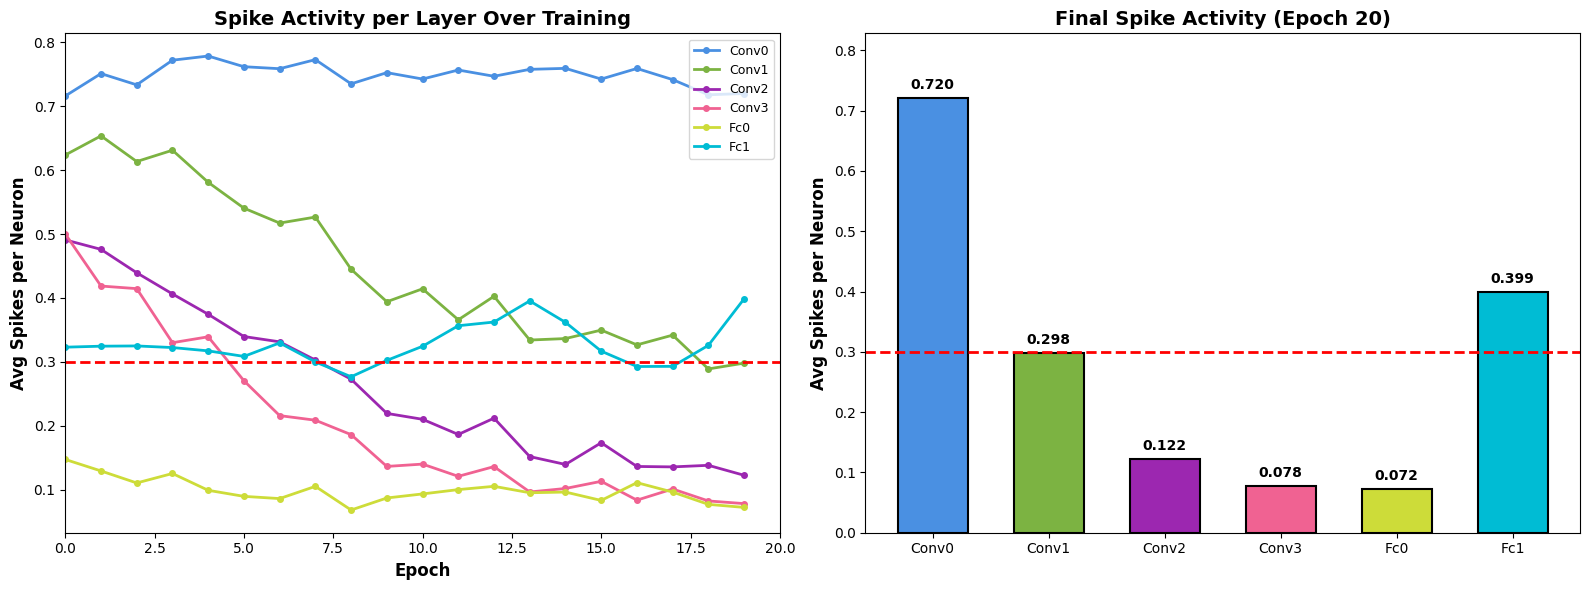

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the data
df = pd.read_csv('SpikesComparison.csv', index_col=0)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Set background color
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax2.set_facecolor('white')

# Define colors to match the image
colors = {
    'Conv0': '#4a90e2',  # Blue
    'Conv1': '#7cb342',  # Green
    'Conv2': '#9c27b0',  # Purple
    'Conv3': '#f06292',  # Pink
    'Fc0': '#cddc39',    # Yellow-green
    'Fc1': '#00bcd4'     # Cyan
}

# IBM Target line
ibm_target = 0.3

# ========== LEFT PLOT: Spike Activity Over Training ==========
for layer in ['Conv0', 'Conv1', 'Conv2', 'Conv3', 'Fc0', 'Fc1']:
    layer_data = df[df['Layer'] == layer].sort_values('index').reset_index(drop=True)
    # Create epoch numbers (0-19 for the 20 data points per layer)
    epochs = range(len(layer_data))
    ax1.plot(epochs, layer_data['SpikePerNeuron'], 
            linewidth=2, marker='o', markersize=4, 
            label=layer, color=colors[layer])

# IBM Target line
ax1.axhline(y=ibm_target, color='red', linestyle='--', linewidth=2)

ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Avg Spikes per Neuron', fontsize=12, fontweight='bold')
ax1.set_title('Spike Activity per Layer Over Training', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.set_xlim(0, 20)

# ========== RIGHT PLOT: Final Spike Activity (Epoch 20) ==========
# Get final epoch data (last value for each layer)
final_data = {}
for layer in ['Conv0', 'Conv1', 'Conv2', 'Conv3', 'Fc0', 'Fc1']:
    layer_values = df[df['Layer'] == layer]['SpikePerNeuron'].values
    final_data[layer] = layer_values[-1]  # Get last value

layers = list(final_data.keys())
values = list(final_data.values())

# Create bar chart
bars = ax2.bar(layers, values, color=[colors[l] for l in layers], 
               edgecolor='black', linewidth=1.5, width=0.6)

# IBM Target line
ax2.axhline(y=ibm_target, color='red', linestyle='--', linewidth=2)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylabel('Avg Spikes per Neuron', fontsize=12, fontweight='bold')
ax2.set_title('Final Spike Activity (Epoch 20)', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(values) * 1.15)

plt.tight_layout()
plt.savefig('./plots/spike_profiles.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
print("✓ Saved: spike_profiles.png")
plt.show()

✓ Saved: training_metrics.png


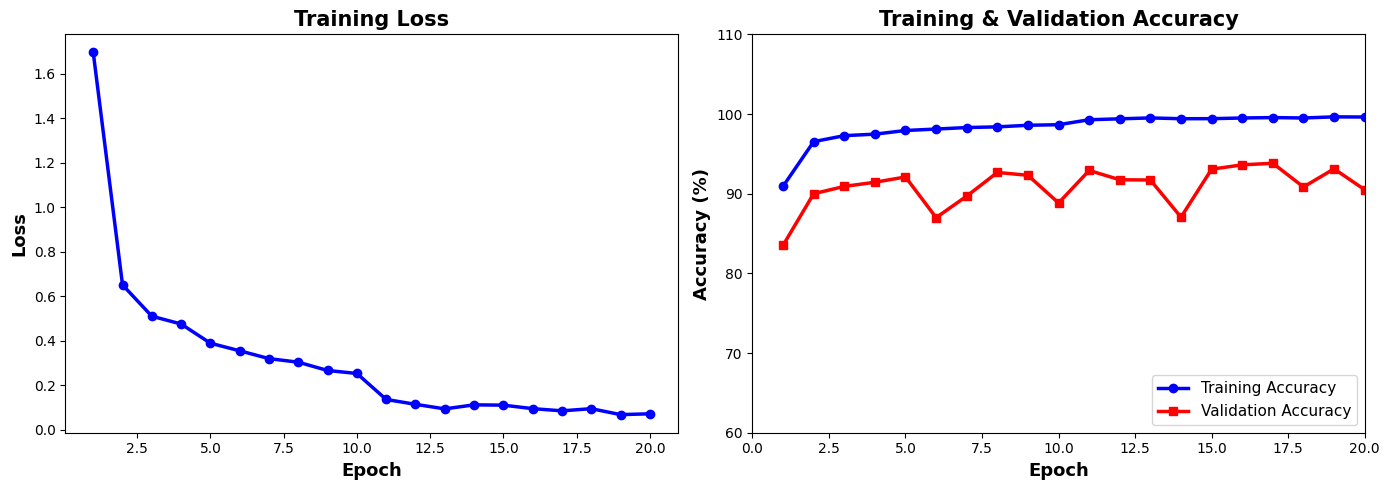

In [93]:
import matplotlib.pyplot as plt
import torch

# Load the history
history = torch.load('training_history.pth', weights_only=False)

# Extract training history data
train_history = history['training_history']
train_losses = train_history['train_losses']
train_accuracies = train_history['train_accuracies']
val_accuracies = train_history['val_accuracies']

# Create epochs list
epochs = range(1, len(train_losses) + 1)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ========== LEFT PLOT: Training Loss ==========
ax1.plot(epochs, train_losses, 'b-', linewidth=2.5, marker='o', markersize=6)
ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax1.set_title('Training Loss', fontsize=15, fontweight='bold')

# ========== RIGHT PLOT: Training & Validation Accuracy ==========
ax2.plot(epochs, train_accuracies, 'b-', linewidth=2.5, marker='o', 
         markersize=6, label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', linewidth=2.5, marker='s', 
         markersize=6, label='Validation Accuracy')
ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax2.set_title('Training & Validation Accuracy', fontsize=15, fontweight='bold')
ax2.legend(fontsize=11, loc='lower right')
ax2.set_ylim(60, 110)  # Set y-axis to start from 60
ax2.set_xlim(0, len(train_losses))  # Set x-axis to start from 0

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
print("✓ Saved: training_metrics.png")
plt.show()

In [94]:
model = SpikingCNN_NCARS_TTFS()  # Initialize your model
checkpoint = torch.load('ttfs_snn_majority_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [100]:
model.eval()

SpikingCNN_NCARS_TTFS(
  (conv0): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ttfs0): TTFSConvNeuron()
  (pool0): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ttfs1): TTFSConvNeuron()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ttfs2): TTFSConvNeuron()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ttfs3)

Using device: cuda
ERROR! Session/line number was not unique in database. History logging moved to new session 1908


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 135/135 [15:48<00:00,  7.03s/batch]


Test Accuracy: 0.9381
AUC: 0.9380306845741514


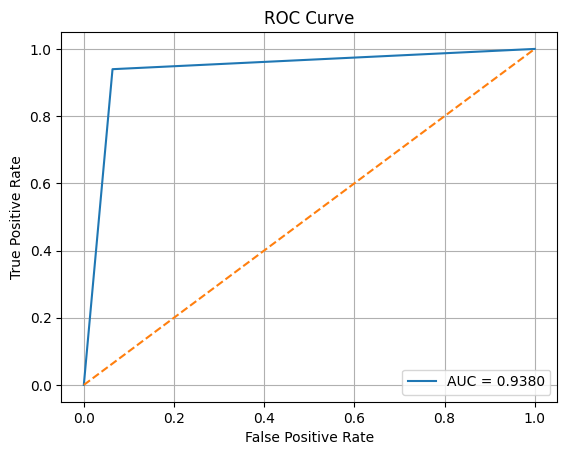

In [103]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# ============================
# Load Model & Move to GPU
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SpikingCNN_NCARS_TTFS()  # Your model class
checkpoint = torch.load("ttfs_snn_majority_best.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

# ============================
# Inference + Collect Results
# ============================
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for data, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
        data = data.to(device, non_blocking=True)

        outputs = model(data)                     # logits
        probs = F.softmax(outputs, dim=1)         # convert to probabilities
        _, preds = torch.max(probs, 1)            # predicted class

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# ============================
# Compute Accuracy
# ============================
acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc:.4f}")

# ============================
# ROC Curve + AUC
# ============================
# Probability of positive class (class index 1)
y_true = all_labels
y_score = all_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# ============================
# Plot ROC curve
# ============================
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")         # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
